This notebook addresses multivariate analysis for extract mixing experiments. All images were passed through the pipeline reported in this paper. In this notebook, we have focused on demonstrating, how one can pick most interesting variables from a multivariate data set. To run the notebook with your own input, just substitute the respective paths.    
     
Interesting questions:   
* how will classifier handle the mixing situation if we removed chromatin related features? 
* which variables distinguish CSF and STG8 spindles best? (chromatin and DNA related features perform best)  
    * how well will the classification perform if the chromatin/DNA related features are removed
* is this difference step-like or gradual? (for all? for some?)
* have a look at the spindles that get misclassified; do they tell you something? (not many do)
* are the same features **low variance features** in all experiments (compare with the other three cases we are investigating)


####Table of contents:   
1. Data folder  
2. Dataset preparation
    * building the dataset (subsample CSF - it is unbalanced at the moment; approach 1 - hard split)
    * feature removal (missing values-only and zero-variance), feature engineering (Euclidian distance)
    * feature transformation
    * feature selection, predictor importance (F-test, Kruskal-Wallis, KS, tree, RFE)    
3. Classification models: CSF and STG8
2. Feature description and pre-processing    
3. Feature selection and engineering    


#I. Data folder

In [1]:
!ls ../../A_PAPER2_PIPELINE/STG8_CSF_Mixing/

DefaultDB.db                 MyExpt_FilteredChromatin.csv
DefaultDB_MyExpt.properties  MyExpt_FilteredSpindles.csv
DefaultOUT.h5                MyExpt_Image.csv
MyExpt_Chromatin.csv         MyExpt_PreSpindles.csv
MyExpt_Experiment.csv        MyExpt_Spindles.csv


If you open any of the csv files in Excel and click any of the cells outside the data cells, they will become active and Unix commands will pick them up as your data dimensions (same for the Python libraries reading in the data).

In [2]:
#!head -n2 ../../A_PAPER2_PIPELINE/STG8_CSF_Mixing/MyExpt_FilteredSpindles.csv | awk 'BEGIN{FS=","}{print NF}'

#II. Dataset preparation    
##Building dataset
STG data comes from the STG8 (800). CSF data comes from the 'complete' data set. All mixing experiments come from the ST8_CSF_mixing.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.mpl_style','default')

import sklearn

%load_ext rpy2.ipython
%matplotlib inline

Columns ObjectNumber and Number_Object_Number are identical in df_mix.

In [4]:
df_mix=pd.read_csv('../../A_PAPER2_PIPELINE/STG8_CSF_Mixing/MyExpt_FilteredSpindles.csv')
df_STG8=pd.read_csv('../../A_PAPER2_PIPELINE/STG8/CoO05_Stream_STG8/MyExpt_FilteredSpindles.csv')
meta=pd.read_table('../Data/columns_meta.txt',header=None,names=['meta_columns'])
df_complete=pd.read_csv('../../A_PAPER2_PIPELINE/Complete Dataset/Dataset/MyExpt_FilteredSpindles.csv')

The **target** column should be **Metadata_Treatment** or **Metadata_Type**.

In [5]:
np.unique(df_mix['Metadata_Treatment'])

array([800, 850, 875, 890])

In [6]:
np.unique(df_mix['Metadata_Type'])

array(['STG'], dtype=object)

In [7]:
np.unique(df_mix['Metadata_Experiment'])

array(['Exp14', 'Exp16'], dtype=object)

In [8]:
df_mix.groupby(['Metadata_Experiment','Metadata_Treatment']).count()

ImageNumber  ObjectNumber  \
Metadata_Experiment Metadata_Treatment                              
Exp14               800                         147           147   
                    850                          69            69   
                    875                         100           100   
                    890                         105           105   
Exp16               800                         100           100   
                    850                         148           148   
                    875                         274           274   
                    890                         247           247   

                                        Metadata_Experimenter  \
Metadata_Experiment Metadata_Treatment                          
Exp14               800                                   147   
                    850                                    69   
                    875                                   100   
                    890                                   105   
Exp16               800                                   100   
                    850                                   148   
                    875                                   274   
                    890                                   247   

                                        Metadata_FileLocation  Metadata_Frame  \
Metadata_Experiment Metadata_Treatment                                          
Exp14               800                                     0             147   
                    850                                     0              69   
                    875                                     0             100   
                    890                                     0             105   
Exp16               800                                     0             100   
                    850                                     0             148   
                    875                                     0             274   
                    890                                     0             247   

                                        Metadata_Series  Metadata_Set  \
Metadata_Experiment Metadata_Treatment                                  
Exp14               800                             147           147   
                    850                              69            69   
                    875                             100           100   
                    890                             105           105   
Exp16               800                             100           100   
                    850                             148           148   
                    875                             274           274   
                    890                             247           247   

                                        Metadata_Type  Metadata_cvsp  \
Metadata_Experiment Metadata_Treatment                                 
Exp14               800                           147            147   
                    850                            69             69   
                    875                           100            100   
                    890                           105            105   
Exp16               800                           100            100   
                    850                           148            148   
                    875                           274            274   
                    890                           247            247   

                                        AreaShape_Area      ...       \
Metadata_Experiment Metadata_Treatment                      ...        
Exp14               800                            147      ...        
                    850                             69      ...        
                    875                            100      ...        
                    890                            105      ...        
Exp

In [9]:
df_mix.drop(df_mix.columns[-1],axis=1, inplace=True)

The above dataframe (df) contains the mixing data (4 middle panels), 
Order:  
* 800 - 100% Stage 8
* 890 - 90% Stage 8
* 875 - 75% Stage 8
* 850 - 50% Stage 8    
     
For the 'population' conditions, we'll take the MEC-STG-800 from STG8 dataframe (df_STG8) and all CSF from complete dataset (df_complete).




For boundary conditions, we'll use the content of **STG8** folder.

In [10]:
df_STG8.groupby(['Metadata_Experiment','Metadata_Treatment','Metadata_Type']).count()

ImageNumber  \
Metadata_Experiment Metadata_Treatment Metadata_Type                
Exp01               800                STG                     26   
Exp02               800                STG                      3   
Exp03               0                  CSF                     54   
Exp04               420                CSF                    102   
Exp05               0                  CSF                     64   
                    800                STG                     65   
Exp06               800                STG                    268   
Exp07               0                  CSF                    132   
Exp08               0                  CSF                    254   
                    800                STG                    300   
Exp09               0                  CSF                     22   
                    800                STG                      6   
Exp11               0                  CSF                     93   
                    800                STG                     75   
Exp13               0                  CSF                     28   
                    800                STG                     50   
Exp14               800                STG                    147   
                    850                STG                     69   
                    875                STG                    100   
                    890                STG                    105   
Exp15               800                STG                     52   
                    890                STG                      8   
                    895                STG                     25   
                    899                STG                     19   
Exp16               800                STG                    100   
                    850                STG                    148   
                    875                STG                    274   
                    890                STG                    247   

                                                      ObjectNumber  \
Metadata_Experiment Metadata_Treatment Metadata_Type                 
Exp01               800                STG                      26   
Exp02               800                STG                       3   
Exp03               0                  CSF                      54   
Exp04               420                CSF                     102   
Exp05               0                  CSF                      64   
                    800                STG                      65   
Exp06               800                STG                     268   
Exp07               0                  CSF                     132   
Exp08               0                  CSF                     254   
                    800                STG                     300   
Exp09               0                  CSF                      22   
                    800                STG                       6   
Exp11               0                  CSF                      93   
                    800                STG                      75   
Exp13               0                  CSF                      28   
                    800                STG                      50   
Exp14               800                STG                     147   
                    850                STG                      69   
                    875                STG                     100   
                    890                STG                     105   
Exp15               800                STG                      52   
                    890                STG                       8   
                    895                STG                      25   
                    899                STG                      19   
Exp16               800                STG                     100   
                    850                STG                     148   
                    875

Part 1 of 3: (STG8 - population)

In [11]:
df_mix.head()

,ImageNumber,ObjectNumber,Metadata_Experiment,Metadata_Experimenter,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_Set,Metadata_Treatment,Metadata_Type,...,Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine,Mean_FilteredChromatin_Location_Center_X,Mean_FilteredChromatin_Location_Center_Y,Mean_FilteredChromatin_Location_MaxIntensity_X_DNA,Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine,Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA,Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine,Mean_FilteredChromatin_Number_Object_Number,Number_Object_Number,Parent_Spindles
0,1,1,Exp14,MEC,NaN,0,0,cvsp1_1,800,STG,...,254.139998,579.448840,254.848567,582,556,257,233,1,1,2
1,1,2,Exp14,MEC,NaN,0,0,cvsp1_1,800,STG,...,462.254761,604.993315,462.199198,601,628,470,457,2,2,3
2,1,3,Exp14,MEC,NaN,0,0,cvsp1_1,800,STG,...,478.138759,573.676951,477.851180,574,558,473,484,3,3,4
3,1,4,Exp14,MEC,NaN,0,0,cvsp1_1,800,STG,...,861.283227,1061.517517,862.483980,1014,1026,884,860,4,4,6
4,2,1,Exp14,MEC,NaN,0,0,cvsp1_10,800,STG,...,476.364239,759.346665,476.356138,746,775,469,436,1,1,2


In [12]:
df_mix['Original_Dataset']=np.repeat(['df_mix'], np.shape(df_mix)[0])

In [13]:
np.shape(df_mix)

(1190, 204)

In [14]:
df_mix_800=df_mix[df_mix.Metadata_Treatment==800]
print df_mix_800.shape
df_mix_850=df_mix[df_mix.Metadata_Treatment==850]
print df_mix_850.shape
df_mix_875=df_mix[df_mix.Metadata_Treatment==875]
print df_mix_875.shape
df_mix_890=df_mix[df_mix.Metadata_Treatment==890]
print df_mix_890.shape

(247, 204)
(217, 204)
(374, 204)
(352, 204)


Part 2 of 3: (mixing experiments)

In [15]:
STG8_all=df_STG8[df_STG8['Metadata_Type']=='STG']

In [16]:
np.shape(STG8_all)

(2087, 203)

In [17]:
STG8_all['Original_Dataset']=np.repeat(['ST8_all'],np.shape(STG8_all)[0])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
np.shape(STG8_all)

(2087, 204)

Part 3 of 3: (CSF spindles)

In [19]:
np.shape(df_complete[df_complete['Metadata_Type']=='CSF'])

(3623, 203)

In [20]:
CSF_all=df_complete[df_complete['Metadata_Type']=='CSF']

In [21]:
CSF_all['Original_Dataset']=np.repeat(['df_complete'], np.shape(CSF_all)[0])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
np.shape(CSF_all)

(3623, 204)

In [23]:
CSF_STG8=pd.concat([STG8_all,CSF_all])

In [24]:
CSF_STG8.shape

(5710, 204)

In [25]:
target=map(lambda x: {'CSF':0, 'STG':1}[x], CSF_STG8['Metadata_Type'])

Mixing datasets for testing classifier performance. These datasets will onlhy be used as OoS. The hypothesis is that, as you add CSF extract to the STG8 extract, you loose characteristics of STG8 and mis-classification becomes more common.

In [26]:
df_mix_800=df_mix[df_mix.Metadata_Treatment==800]
df_mix_800=pd.concat([df_mix_800,CSF_all.iloc[0:248,:]])
print df_mix_800.shape
df_mix_850=df_mix[df_mix.Metadata_Treatment==850]
df_mix_850=pd.concat([df_mix_850,CSF_all.iloc[0:220,:]])
print df_mix_850.shape
df_mix_875=df_mix[df_mix.Metadata_Treatment==875]
df_mix_875=pd.concat([df_mix_875,CSF_all.iloc[0:375,:]])
print df_mix_875.shape
df_mix_890=df_mix[df_mix.Metadata_Treatment==890]
df_mix_890=pd.concat([df_mix_890,CSF_all.iloc[0:352,:]])
print df_mix_890.shape

(495, 204)
(437, 204)
(749, 204)
(704, 204)


In [27]:
print list(df_mix_800.columns[-10:])
print list(CSF_STG8.columns[-10:])

['Mean_FilteredChromatin_Location_Center_X', 'Mean_FilteredChromatin_Location_Center_Y', 'Mean_FilteredChromatin_Location_MaxIntensity_X_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine', 'Mean_FilteredChromatin_Number_Object_Number', 'Number_Object_Number', 'Parent_Spindles', 'Original_Dataset']
['Mean_FilteredChromatin_Location_Center_X', 'Mean_FilteredChromatin_Location_Center_Y', 'Mean_FilteredChromatin_Location_MaxIntensity_X_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine', 'Mean_FilteredChromatin_Number_Object_Number', 'Number_Object_Number', 'Parent_Spindles', 'Original_Dataset']


###Preliminary feature selection and engineering
We will **remove metadata** columns, **add back target** column, **add Euclidian distance** column, **remove locator** columns, **remove missing data** columns.     
     
Added in this version of the notebook. The analysis will be done without the DNA/chromatin related variables). 

Meta data:

In [28]:
list(meta.meta_columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp',
 'Number_Object_Number']

Missing values (note that these are the same columns as in the TPX2 dataset):

In [29]:
list(np.sum(CSF_STG8.isnull()==True)[np.sum(CSF_STG8.isnull()==True)!=0].index)

['Metadata_FileLocation',
 'Mean_FilteredChromatin_Distance_Centroid_FilteredSpindles',
 'Mean_FilteredChromatin_Distance_Minimum_FilteredSpindles']

In [30]:
NAs=list(np.sum(CSF_STG8.isnull()==True)[np.sum(CSF_STG8.isnull()==True)!=0].index)

In [31]:
CSF_STG8.shape

(5710, 204)

Euclidian distance between geometric center and center of detected object:

In [32]:
def Euclidian_norm(x1,x2,y1,y2):
    a_sq=(np.abs(x1-x2))**2
    b_sq=(np.abs(y1-y2))**2
    c=np.sqrt(a_sq+b_sq)
    return c

In [33]:
CSF_STG8['Euclidian_norm_centers']=Euclidian_norm(CSF_STG8.AreaShape_Center_X,CSF_STG8.Location_Center_X,CSF_STG8.AreaShape_Center_Y,CSF_STG8.Location_Center_Y)

In [34]:
df_mix_800['Euclidian_norm_centers']=Euclidian_norm(df_mix_800.AreaShape_Center_X,df_mix_800.Location_Center_X,df_mix_800.AreaShape_Center_Y,df_mix_800.Location_Center_Y)
df_mix_850['Euclidian_norm_centers']=Euclidian_norm(df_mix_850.AreaShape_Center_X,df_mix_850.Location_Center_X,df_mix_850.AreaShape_Center_Y,df_mix_850.Location_Center_Y)
df_mix_875['Euclidian_norm_centers']=Euclidian_norm(df_mix_875.AreaShape_Center_X,df_mix_875.Location_Center_X,df_mix_875.AreaShape_Center_Y,df_mix_875.Location_Center_Y)
df_mix_890['Euclidian_norm_centers']=Euclidian_norm(df_mix_890.AreaShape_Center_X,df_mix_890.Location_Center_X,df_mix_890.AreaShape_Center_Y,df_mix_890.Location_Center_Y)


In [35]:
print list(df_mix_800.columns[-10:])
print list(CSF_STG8.columns[-10:])

['Mean_FilteredChromatin_Location_Center_Y', 'Mean_FilteredChromatin_Location_MaxIntensity_X_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine', 'Mean_FilteredChromatin_Number_Object_Number', 'Number_Object_Number', 'Parent_Spindles', 'Original_Dataset', 'Euclidian_norm_centers']
['Mean_FilteredChromatin_Location_Center_Y', 'Mean_FilteredChromatin_Location_MaxIntensity_X_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA', 'Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine', 'Mean_FilteredChromatin_Number_Object_Number', 'Number_Object_Number', 'Parent_Spindles', 'Original_Dataset', 'Euclidian_norm_centers']


Object locators:

In [36]:
object_locators = pd.read_table('../Data/columns_obj_locators_ext.txt',header=None,names=['loc_columns'])

Dropping: metadata, object locators, missing values.

In [37]:
to_drop=NAs+list(meta.meta_columns)+list(object_locators.loc_columns)

In [38]:
CSF_STG8.shape #before

(5710, 205)

In [39]:
CSF_STG8.drop(to_drop,axis=1,inplace=True)
CSF_STG8.shape #after

(5710, 169)

In [40]:
#target=map(lambda x: {'CSF':0, 'STG':1}[x], CSF_STG8['Metadata_Type'])
Y_800=map(lambda x: {'CSF':0, 'STG':1}[x],df_mix_800['Metadata_Type'])
df_mix_800.drop(to_drop,axis=1,inplace=True)
print df_mix_800.shape
Y_850=map(lambda x: {'CSF':0, 'STG':1}[x],df_mix_850['Metadata_Type'])
df_mix_850.drop(to_drop,axis=1,inplace=True)
print df_mix_850.shape
Y_875=map(lambda x: {'CSF':0, 'STG':1}[x],df_mix_875['Metadata_Type'])
df_mix_875.drop(to_drop,axis=1,inplace=True)
print df_mix_875.shape
Y_890=map(lambda x: {'CSF':0, 'STG':1}[x],df_mix_890['Metadata_Type'])
df_mix_890.drop(to_drop,axis=1,inplace=True)
print df_mix_890.shape

(495, 169)
(437, 169)
(749, 169)
(704, 169)


Pay attention to 'Original_Dataset'. 

In [41]:
source_CSF_STG8 = CSF_STG8['Original_Dataset']
CSF_STG8.drop('Original_Dataset',axis=1, inplace=True)
CSF_STG8.shape

(5710, 168)

In [42]:
df_mix_800.drop('Original_Dataset',axis=1,inplace=True)
print df_mix_800.shape
df_mix_850.drop('Original_Dataset',axis=1,inplace=True)
print df_mix_850.shape
df_mix_875.drop('Original_Dataset',axis=1,inplace=True)
print df_mix_875.shape
df_mix_890.drop('Original_Dataset',axis=1,inplace=True)
print df_mix_890.shape

(495, 168)
(437, 168)
(749, 168)
(704, 168)


Adding Target column

In [43]:
CSF_STG8['Target']=target
CSF_STG8.shape

(5710, 169)

In [44]:
#df_mix_800['Target']=Y_800
#df_mix_800.shape
#df_mix_890['Target']=Y_890
#df_mix_890.shape
#df_mix_875['Target']=Y_875
#df_mix_875.shape
#df_mix_850['Target']=Y_850
#df_mix_850.shape

Find and remove chromatin/DNA releated features.

In [45]:
chromatin_vars=[]

for col in list(CSF_STG8.columns):
    if re.match('.*chromatin.*',col,re.IGNORECASE) != None:
        print re.match('.*chromatin.*',col,re.IGNORECASE).group(0)
        chromatin_vars.append(re.match('.*chromatin.*',col,re.IGNORECASE).group(0))

    elif re.match('.*DNA.*',col,re.IGNORECASE) != None:
        print re.match('.*DNA.*',col,re.IGNORECASE).group(0)
        chromatin_vars.append(re.match('.*DNA.*',col,re.IGNORECASE).group(0))


Children_FilteredChromatin_Count
Intensity_IntegratedIntensityEdge_DNA
Intensity_IntegratedIntensity_DNA
Intensity_LowerQuartileIntensity_DNA
Intensity_MADIntensity_DNA
Intensity_MassDisplacement_DNA
Intensity_MaxIntensityEdge_DNA
Intensity_MaxIntensity_DNA
Intensity_MeanIntensityEdge_DNA
Intensity_MeanIntensity_DNA
Intensity_MedianIntensity_DNA
Intensity_MinIntensityEdge_DNA
Intensity_MinIntensity_DNA
Intensity_StdIntensityEdge_DNA
Intensity_StdIntensity_DNA
Intensity_UpperQuartileIntensity_DNA
Math_SpindletoChromatinArea
Math_TotalChromatinArea
Math_TotalChromatinIntegratedIntensity
Math_TotalChromatinMaxFeret
Math_TotalChromatinPerimeter
Mean_FilteredChromatin_AreaShape_Area
Mean_FilteredChromatin_AreaShape_Center_X
Mean_FilteredChromatin_AreaShape_Center_Y
Mean_FilteredChromatin_AreaShape_Compactness
Mean_FilteredChromatin_AreaShape_Eccentricity
Mean_FilteredChromatin_AreaShape_EulerNumber
Mean_FilteredChromatin_AreaShape_Extent
Mean_FilteredChromatin_AreaShape_FormFactor
Mean_Filt

In [46]:
print chromatin_vars.__len__()
chromatin_vars_2=pd.read_table('../Data/columns_chromatin_v2.txt',header=None,names=['to_delete'])
print chromatin_vars_2.__len__()

100
91


In [47]:
chromatin_vars_2=list(chromatin_vars_2.to_delete)

In [48]:
CSF_STG8.drop(chromatin_vars_2,axis=1,inplace=True)
print CSF_STG8.shape
df_mix_800.drop(chromatin_vars_2,axis=1,inplace=True)
print df_mix_800.shape
df_mix_850.drop(chromatin_vars_2,axis=1,inplace=True)
print df_mix_850.shape
df_mix_875.drop(chromatin_vars_2,axis=1,inplace=True)
print df_mix_875.shape
df_mix_890.drop(chromatin_vars_2,axis=1,inplace=True)
print df_mix_890.shape

(5710, 78)
(495, 77)
(437, 77)
(749, 77)
(704, 77)


In [49]:
CSF_STG8.columns[-10:]

Index([u'Math_TotalChromatinIntegratedIntensity',
       u'Math_TotalChromatinMaxFeret', u'Math_TotalChromatinPerimeter',
       u'Mean_FilteredChromatin_AreaShape_Area',
       u'Mean_FilteredChromatin_AreaShape_Eccentricity',
       u'Mean_FilteredChromatin_AreaShape_Solidity',
       u'Mean_FilteredChromatin_AreaShape_Zernike_0_0', u'Parent_Spindles',
       u'Euclidian_norm_centers', u'Target'],
      dtype='object')

###Zero-variance feature removal

Removing features with zero-variance. Keeping near-zero ones for now. The first attempt is with the scikit-learn.


Let's map the variable name to the value of the first row.

In [50]:
print len(CSF_STG8.iloc[0,:])
print len(np.unique(CSF_STG8.iloc[0,:]))
col_info=zip(CSF_STG8.iloc[0,:],CSF_STG8.columns.tolist())

78
77


In [51]:
print(np.sum(CSF_STG8.var()==0.0))
print(CSF_STG8.var()[CSF_STG8.var()==0.0])

1
AreaShape_EulerNumber    0
dtype: float64


There is one value with 0 variance (EulerNumber), but the scikit-learn will also drop the Euclidian_norm_centers (must be sensitivity issue).

In [52]:
np.sort(CSF_STG8.var())

array([  0.00000000e+00,   4.00299869e-08,   3.00345014e-06,
         3.48072570e-06,   3.58909998e-06,   4.62881962e-06,
         4.79727241e-06,   5.25157404e-06,   7.48498148e-06,
         8.10967659e-06,   8.23850997e-06,   8.90477718e-06,
         9.08239174e-06,   1.05233602e-05,   1.17784029e-05,
         1.47422488e-05,   1.47792185e-05,   1.59770027e-05,
         1.67607029e-05,   1.86066740e-05,   1.87485277e-05,
         2.10032525e-05,   2.71806778e-05,   2.80668627e-05,
         3.10542928e-05,   3.13105195e-05,   3.17771366e-05,
         4.39476517e-05,   4.93984584e-05,   5.29529791e-05,
         6.31534473e-05,   6.62673780e-05,   7.81677234e-05,
         8.10023102e-05,   1.15232600e-04,   1.31742261e-04,
         2.17026076e-04,   3.23013799e-04,   3.29238696e-04,
         3.47852980e-04,   8.21226297e-04,   1.61042115e-03,
         1.37680515e-02,   1.50502533e-02,   1.62712450e-02,
         1.64863159e-02,   1.92256036e-02,   1.98678483e-02,
         2.17361537e-02,

In [53]:
from sklearn.feature_selection import VarianceThreshold

We need to do it without the target column.

In [54]:
X=CSF_STG8.iloc[:,:-1].values

In [55]:
selector=VarianceThreshold(threshold=0.0)
selector.fit(X)
selector.get_params()

{'threshold': 0.0}

In [56]:
X_new=selector.fit_transform(X)
X.shape, X_new.shape 

((5710, 77), (5710, 76))

Removed 1 feature. Which one?

In [57]:
X[0,:].shape, X_new[0,:].shape

((77,), (76,))

Above are the dimensions of X before (X) and after (X_new). Target column has been removed.

####Use the functions below to retrieve names of removed features (or features that differ between two related dataframes):

In [58]:
original_col_names = CSF_STG8.columns.tolist()

In [59]:
def main(X, X_new,all_cols):
    diff_features=[]
    for diff_feat in range(X[0,:].shape[0]-X_new[0,:].shape[0]):
        if lengthTester(X, X_new) == True:
            print 'no difference'
            break
        else:
            diff_features.append(all_cols[missingFeatureFinder(X, X_new)])
            all_cols.remove(all_cols[missingFeatureFinder(X, X_new)])
    return diff_features

def lengthTester(X, X_new):
    return len(X[0,:]) == len(X_new[0,:])

def missingFeatureFinder(X, X_new):
    for idx in range(np.shape(X)[1]):
        if np.sum(X[:,idx]==X_new[:,idx]) !=0:
            continue
            #print idx
        elif np.sum(X[:,idx]==X_new[:,idx]) ==0:
            return idx#, CSF_STG8.columns[col]
            break 

In [60]:
main(X, X_new,original_col_names)

['AreaShape_EulerNumber']

Let's see whether the **caret package** is more user-friendly. If it is, we'll re-use it on the transformed data set below (for comparison).

X_new has no Target column. 

In [61]:
X_new.shape

(5710, 76)

In [62]:
%R -i CSF_STG8

In [63]:
%%R
dim(CSF_STG8)

[1] 5710   78


In [64]:
%%R
library(caret)
CSF_STG8.nzv.vars=nearZeroVar(CSF_STG8, saveMetrics=TRUE)
print(head(CSF_STG8.nzv.vars))

CSF_STG8.nzv=nearZeroVar(CSF_STG8)
print(head(CSF_STG8.nzv))


Loading required package: lattice
Loading required package: ggplot2
                       freqRatio percentUnique zeroVar   nzv
AreaShape_Area                 1   84.99124343   FALSE FALSE
AreaShape_Compactness          1   97.23292469   FALSE FALSE
AreaShape_Eccentricity         1   97.23292469   FALSE FALSE
AreaShape_EulerNumber          0    0.01751313    TRUE  TRUE
AreaShape_Extent               1   96.97022767   FALSE FALSE
AreaShape_FormFactor           1   97.23292469   FALSE FALSE
[1] 4


Which ones were cut? You can see below, that there should be 1.

In [65]:
%%R 
print(CSF_STG8.nzv.vars[CSF_STG8.nzv.vars$zeroVar==TRUE,])
print(CSF_STG8.nzv.vars[CSF_STG8.nzv.vars$nzv==TRUE,])


                      freqRatio percentUnique zeroVar  nzv
AreaShape_EulerNumber         0    0.01751313    TRUE TRUE
                      freqRatio percentUnique zeroVar  nzv
AreaShape_EulerNumber         0    0.01751313    TRUE TRUE


Looks like the two methods converge, but R objects are easier to work with. Below, we'll remove the NZV features.

In [66]:
%%R
print('before:')
print(dim(CSF_STG8))

print('after')
print(dim(CSF_STG8[,-CSF_STG8.nzv]))
CSF_STG8_caret_nzv_mod=CSF_STG8[,-CSF_STG8.nzv]

print(dim(CSF_STG8_caret_nzv_mod))

[1] "before:"
[1] 5710   78
[1] "after"
[1] 5710   77
[1] 5710   77


Above, we have dimensions before and after with target column.

In [67]:
%%R
head(CSF_STG8_caret_nzv_mod)

  AreaShape_Area AreaShape_Compactness AreaShape_Eccentricity AreaShape_Extent
1           4731              1.243906              0.8059862        0.5786448
2          20722              1.931709              0.8899388        0.5369646
3          16907              1.138155              0.7361809        0.6159647
4           3873              2.122788              0.8655789        0.3704448
5          18314              1.092536              0.6619941        0.6960058
6           4193              1.107429              0.6890853        0.5613119
  AreaShape_FormFactor AreaShape_MajorAxisLength AreaShape_MaxFeretDiameter
1            0.3103852                 105.19300                  111.04053
2            0.1690419                 289.87190                  262.42904
3            0.3600622                 182.97507                  187.09623
4            0.1300123                 129.16777                  127.78106
5            0.3182834                 180.27738                  1

Both of the approaches above were applied on the input data frame. Let's see whether we can get the same result on the transformed one.

Starting from the full data set.

###Feature transformation 

In [68]:
%R -i df_mix_800

In [69]:
%R -i df_mix_850

In [70]:
%R -i df_mix_875

In [71]:
%R -i df_mix_890

In [72]:
%R -i CSF_STG8

In [73]:
%%R
print(dim(CSF_STG8))
print(dim(df_mix_800))

[1] 5710   78
[1] 495  77


In [74]:
%%R
print(dim(df_mix_800))
print(names(df_mix_800)[length(names(df_mix_800))])
print(names(CSF_STG8)[length(names(CSF_STG8))])

[1] 495  77
[1] "Euclidian_norm_centers"
[1] "Target"


First, we'll get a summary for each variable. The cell below takes care of the fact that variables in data frames pulled from ipynb are of a class 'array' instead of 'numeric'.

In [75]:
%%R
#see Domino on FA in Evernote and tgmstat on feature selection
library(caret)
library(psych)
CSF_STG8_no_Y=CSF_STG8[,names(CSF_STG8)[-length(names(CSF_STG8))]]
write.csv(describe(CSF_STG8_no_Y), '../Data/mixing_CSF_STG8_no_DNA_no_Y_summary.csv')

for (var in names(CSF_STG8_no_Y)){
    CSF_STG8_no_Y[,var]=as.numeric(CSF_STG8_no_Y[,var])
    #print(class(CSF_STG8_no_Y[,var]))   
}




Attaching package: ‘psych’

The following object is masked from ‘package:ggplot2’:

    %+%



In [76]:
%%R
print(dim(CSF_STG8_no_Y))
print(names(CSF_STG8)[length(names(CSF_STG8))])
print(names(CSF_STG8_no_Y)[length(names(CSF_STG8_no_Y))])

[1] 5710   77
[1] "Target"
[1] "Euclidian_norm_centers"


In [77]:
%%R
for (var in names(df_mix_800)){
    df_mix_800[,var]=as.numeric(df_mix_800[,var])
}

for (var in names(df_mix_850)){
    df_mix_850[,var]=as.numeric(df_mix_850[,var])
}

for (var in names(df_mix_875)){
    df_mix_875[,var]=as.numeric(df_mix_875[,var])
}

for (var in names(df_mix_890)){
    df_mix_890[,var]=as.numeric(df_mix_890[,var])
}


In [78]:
%%R
preProcPars=preProcess(CSF_STG8_no_Y, method=c('BoxCox','center','scale'))
CSF_STG8_no_Y_transformed=predict(preProcPars,CSF_STG8_no_Y)
write.csv(CSF_STG8_no_Y_transformed, file='../Data/mixing_CSF_STG8_no_DNA_no_Y_transf.csv')

In [79]:
%%R
print(dim(CSF_STG8_no_Y_transformed))


[1] 5710   77


In [80]:
%%R
preProcPars800=preProcess(df_mix_800, method=c('BoxCox','center','scale'))
df_mix_800_trans=predict(preProcPars,df_mix_800)
write.csv(df_mix_800_trans,'../Data/mixing_df_mix_800_no_DNA_trans.csv')

preProcPars850=preProcess(df_mix_850, method=c('BoxCox','center','scale'))
df_mix_850_trans=predict(preProcPars,df_mix_850)
write.csv(df_mix_850_trans,'../Data/mixing_df_mix_850_no_DNA_trans.csv')

preProcPars875=preProcess(df_mix_875, method=c('BoxCox','center','scale'))
df_mix_875_trans=predict(preProcPars,df_mix_875)
write.csv(df_mix_875_trans,'../Data/mixing_df_mix_875_no_DNA_trans.csv')

preProcPars890=preProcess(df_mix_890, method=c('BoxCox','center','scale'))
df_mix_890_trans=predict(preProcPars,df_mix_890)
write.csv(df_mix_890_trans,'../Data/mixing_df_mix_890_no_DNA_trans.csv')


In [81]:
%%R
print(dim(df_mix_890_trans))
print(names(df_mix_890_trans)[length(names(df_mix_890_trans))])



[1] 704  77
[1] "Euclidian_norm_centers"


Below is an example outcome of transformation.

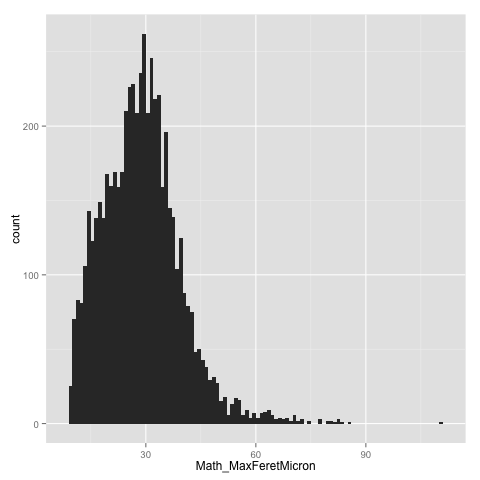

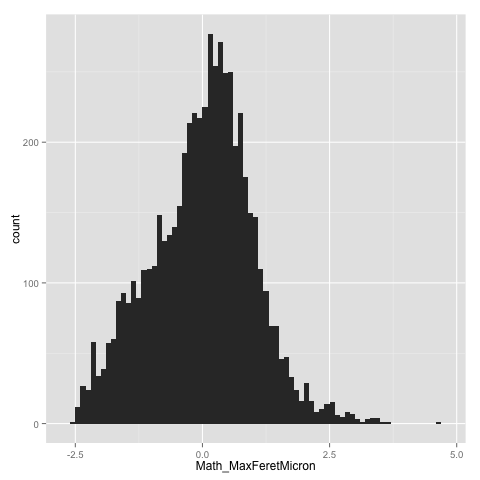

In [82]:
%%R
#hist(CSF_STG8_no_Y$AreaShape_Area,breaks=100)
#hist(CSF_STG8_no_Y_transformed$AreaShape_Area,breaks=100)
#hist(CSF_STG8_no_Y$Math_MaxFeretMicron,breaks=100)
print(ggplot(data=CSF_STG8_no_Y)+geom_histogram(aes(Math_MaxFeretMicron),binwidth=1))
print(ggplot(data=CSF_STG8_no_Y_transformed)+geom_histogram(aes(Math_MaxFeretMicron),binwidth=0.1))#+labs(x='length')

The transformed distribution looks like it has a kurtosis problem but that's probably best one can do.

Now, we'll re-do the near-zero variance correction.

In [83]:
%%R
nzv=nearZeroVar(CSF_STG8_no_Y_transformed)

In [84]:
%%R
nzv.obj=nearZeroVar(CSF_STG8_no_Y_transformed, saveMetrics=TRUE)
print(nzv.obj[nzv.obj$nzv==TRUE,])

                      freqRatio percentUnique zeroVar  nzv
AreaShape_EulerNumber         0    0.01751313    TRUE TRUE


In [85]:
%%R
print(nzv)

CSF_STG8_no_Y_transf_nzv=CSF_STG8_no_Y_transformed[,-nzv]

print(dim(CSF_STG8_no_Y_transf_nzv))
write.csv(CSF_STG8_no_Y_transf_nzv,file='../Data/mixing_CSF_STG8_no_DNA_no_Y_transf_nzv.csv')

[1] 4
[1] 5710   76


##Feature selection - predictive models

In [86]:
CSF_STG8_no_Y_transformed=pd.read_csv('../Data/mixing_CSF_STG8_no_DNA_no_Y_transf.csv')
CSF_STG8_no_Y_transf_nzv=pd.read_csv('../Data/mixing_CSF_STG8_no_DNA_no_Y_transf_nzv.csv')

In [87]:
CSF_STG8_no_Y_transformed.drop('Unnamed: 0',inplace=True,axis=1)
CSF_STG8_no_Y_transf_nzv.drop('Unnamed: 0',inplace=True,axis=1)

In [88]:
print CSF_STG8_no_Y_transformed.shape, CSF_STG8_no_Y_transf_nzv.shape
CSF_STG8_no_Y_transformed.head()

(5710, 77) (5710, 76)


,AreaShape_Area,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,AreaShape_MaxFeretDiameter,AreaShape_MaximumRadius,AreaShape_MeanRadius,...,Math_TotalChromatinArea,Math_TotalChromatinIntegratedIntensity,Math_TotalChromatinMaxFeret,Math_TotalChromatinPerimeter,Mean_FilteredChromatin_AreaShape_Area,Mean_FilteredChromatin_AreaShape_Eccentricity,Mean_FilteredChromatin_AreaShape_Solidity,Mean_FilteredChromatin_AreaShape_Zernike_0_0,Parent_Spindles,Euclidian_norm_centers
0,-0.979573,-0.239731,-0.037384,0,-0.101197,-1.013595,-1.053825,-1.069223,-0.789225,-1.028551,...,1.010925,1.594304,0.522035,0.656943,0.287678,0.255430,-0.118130,0.233244,0.684906,0.635997
1,1.111254,1.398816,0.672258,0,-0.456241,-1.736814,1.658492,1.239468,0.473151,-0.038371,...,1.153387,1.728457,0.322881,0.332392,1.591200,0.362619,0.559343,0.632491,1.221232,1.872113
2,0.785282,-0.784092,-0.573944,0,0.239216,-0.759410,0.324875,0.259594,0.477699,0.498169,...,-0.688299,0.129280,-0.531735,-0.139133,-0.451750,0.317013,-0.238718,-0.532932,0.684906,1.159527
3,-1.218241,1.598379,0.459110,0,-1.609982,-1.936519,-0.568965,-0.731774,-1.828171,-1.862084,...,-2.292397,-2.395262,-2.246115,-1.912958,-1.968832,-0.449968,-0.354791,0.017793,-0.924073,1.493786
4,0.911770,-1.069151,-1.090938,0,1.041034,-0.973182,0.284814,0.269156,0.774104,0.561338,...,-0.859093,-0.252090,-0.221040,0.092132,-1.265960,0.147951,-0.834833,-0.217867,1.650293,0.899236


In [89]:
CSF_STG8_no_Y_transformed['Target'] = list(target)
CSF_STG8_no_Y_transf_nzv['Target'] = list(target)

###Balancing data set
The first approach will be a hard trim. In the second approach we'll use the caret.

In [90]:
CSF_STG8_no_Y_transformed.groupby(['Target']).count()

,AreaShape_Area,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,AreaShape_MaxFeretDiameter,AreaShape_MaximumRadius,AreaShape_MeanRadius,...,Math_TotalChromatinArea,Math_TotalChromatinIntegratedIntensity,Math_TotalChromatinMaxFeret,Math_TotalChromatinPerimeter,Mean_FilteredChromatin_AreaShape_Area,Mean_FilteredChromatin_AreaShape_Eccentricity,Mean_FilteredChromatin_AreaShape_Solidity,Mean_FilteredChromatin_AreaShape_Zernike_0_0,Parent_Spindles,Euclidian_norm_centers
Target,,,,,,,,,,,,,,,,,,,,,
0,3623,3623,3623,3623,3623,3623,3623,3623,3623,3623,...,3623,3623,3623,3623,3623,3623,3623,3623,3623,3623
1,2087,2087,2087,2087,2087,2087,2087,2087,2087,2087,...,2087,2087,2087,2087,2087,2087,2087,2087,2087,2087


We'll take the first 2000 rows for STG and last 2000 for CSF.

In [91]:
CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']==0].iloc[0:2000,:].shape
X1_train_CSF=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']==0].iloc[0:2000,:]
X1_OoS_CSF=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']==0].iloc[2000:2100,:]

X1_train_STG=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']==1].iloc[0:2000,:]
X1_OoS_STG=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']==1].iloc[2000:,:]

X1_train_input = pd.concat([X1_train_CSF,X1_train_STG])
X1_OoS =pd.concat([X1_OoS_CSF,X1_OoS_STG])

In [92]:
#CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']=='CSF'].iloc[0:2000,:].shape
#X1_train_CSF=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']=='CSF'].iloc[0:2000,:]
#X1_OoS_CSF=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']=='CSF'].iloc[2000:2100,:]

#X1_train_STG=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']=='STG'].iloc[0:2000,:]
#X1_OoS_STG=CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']=='STG'].iloc[2000:,:]

#X1_train_input = pd.concat([X1_train_CSF,X1_train_STG])
#X1_OoS =pd.concat([X1_OoS_CSF,X1_OoS_STG])

In [93]:
CSF_STG8_no_Y_transformed[CSF_STG8_no_Y_transformed['Target']==0].iloc[2000:,:].shape

(1623, 78)

In [94]:
X2_train_CSF=CSF_STG8_no_Y_transf_nzv[CSF_STG8_no_Y_transf_nzv['Target']==0].iloc[0:2000,:]
X2_OoS_CSF=CSF_STG8_no_Y_transf_nzv[CSF_STG8_no_Y_transf_nzv['Target']==0].iloc[2000:2100,:]

X2_train_STG=CSF_STG8_no_Y_transf_nzv[CSF_STG8_no_Y_transf_nzv['Target']==1].iloc[0:2000,:]
X2_OoS_STG=CSF_STG8_no_Y_transf_nzv[CSF_STG8_no_Y_transf_nzv['Target']==1].iloc[2000:2100,:]

X2_train_input = pd.concat([X2_train_CSF,X2_train_STG])
X2_OoS =pd.concat([X2_OoS_CSF,X2_OoS_STG])

In [95]:
list(X2_train_input.columns)

['AreaShape_Area',
 'AreaShape_Compactness',
 'AreaShape_Eccentricity',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'AreaShape_Zernike_0_0',
 'AreaShape_Zernike_1_1',
 'AreaShape_Zernike_2_0',
 'AreaShape_Zernike_2_2',
 'AreaShape_Zernike_3_1',
 'AreaShape_Zernike_3_3',
 'AreaShape_Zernike_4_0',
 'AreaShape_Zernike_4_2',
 'AreaShape_Zernike_4_4',
 'AreaShape_Zernike_5_1',
 'AreaShape_Zernike_5_3',
 'AreaShape_Zernike_5_5',
 'AreaShape_Zernike_6_0',
 'AreaShape_Zernike_6_2',
 'AreaShape_Zernike_6_4',
 'AreaShape_Zernike_6_6',
 'AreaShape_Zernike_7_1',
 'AreaShape_Zernike_7_3',
 'AreaShape_Zernike_7_5',
 'AreaShape_Zernike_7_7',
 'AreaShape_Zernike_8_0',
 'AreaShape_Zernike_8_2',
 'AreaShape_Zernike_8_4',
 'AreaSha

In [96]:
Y1=X1_train_input['Target'].values
Y2=X2_train_input['Target'].values

In [97]:
X1_train_input.drop('Target',axis=1, inplace=True)
X2_train_input.drop('Target',axis=1, inplace=True)

In [98]:
X1_train_input.shape, X2_train_input.shape

((4000, 77), (4000, 76))

Target is the Y (outcome to be predicted). CSF is 0 and STG8 is 1.

#####Model 1: all features without DNA/chromatin
Dataset is transformed, scaled and centered. It will, however, be affected by **multicollinearity** at this stage. Decrease dimensions before moving forward.

In [99]:
from sklearn.linear_model import LogisticRegression

from sklearn.cross_validation import train_test_split


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

In [100]:
np.unique(target) 

array([0, 1])

Specyfying X and Y.

In [101]:
#Y=target.values
X1=X1_train_input.values
X2=X2_train_input.values

Splitting data set for cross-validation:

In [102]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=0)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=0)

In [103]:
X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, Y1_train.shape, Y1_test.shape, X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, Y2_train.shape, Y2_test.shape 

((3200, 77),
 (800, 77),
 (3200, 76),
 (800, 76),
 (3200,),
 (800,),
 (3200, 77),
 (800, 77),
 (3200, 76),
 (800, 76),
 (3200,),
 (800,))

In [104]:
m1_1=LogisticRegression(penalty ='l2', C=1) 
m2_1=LogisticRegression(penalty ='l2', C=1) 


m1_1.fit(X1_train,Y1_train)
m2_1.fit(X2_train,Y2_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [105]:
Y_pred_1_1=m1_1.predict(X1_test)
Y_pred_2_1=m2_1.predict(X2_test)

In [106]:
print accuracy_score(Y1_test, Y_pred_1_1)
print accuracy_score(Y2_test, Y_pred_2_1)

0.88625
0.88625


[[361  46]
 [ 45 348]]
[[361  46]
 [ 45 348]]


<matplotlib.colorbar.Colorbar instance at 0x11a657dd0>

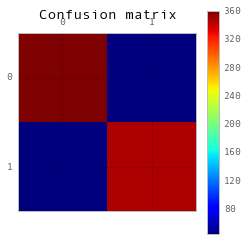

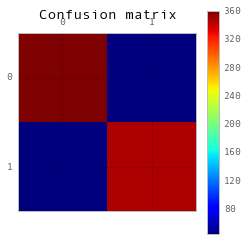

In [107]:
cm_1_1=confusion_matrix(Y1_test, Y_pred_1_1)
print(cm_1_1)
plt.matshow(cm_1_1)
plt.title('Confusion matrix')
plt.colorbar()
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
cm_2_1=confusion_matrix(Y2_test, Y_pred_2_1)
print(cm_2_1)
plt.matshow(cm_2_1)
plt.title('Confusion matrix')
plt.colorbar()


In [108]:
print(classification_report(Y1_test, Y_pred_1_1))
print
print(classification_report(Y2_test, Y_pred_2_1))

             precision    recall  f1-score   support

          0       0.89      0.89      0.89       407
          1       0.88      0.89      0.88       393

avg / total       0.89      0.89      0.89       800


             precision    recall  f1-score   support

          0       0.89      0.89      0.89       407
          1       0.88      0.89      0.88       393

avg / total       0.89      0.89      0.89       800



Skipping DNA/chromatin features makes the model far less accurate. 

Evaluating **model performance**:

In [109]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
n_samples = len(Y1)
cv = ShuffleSplit(n_samples, n_iter=10, test_size=0.2, random_state=0) #5-fold

test_scores_1_1 = cross_val_score(LogisticRegression(penalty = 'l2', C=1), X1, Y1, cv=cv)
test_scores_2_1 = cross_val_score(LogisticRegression(penalty = 'l2', C=1), X2, Y2, cv=cv)


#print(test_scores)
print test_scores_1_1.mean()
print test_scores_2_1.mean()



0.896875
0.896875


Does not look like the two removed features had so much of an impact on the boundary.

In [110]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [111]:
def plot_roc_curve(target_test, target_predicted_proba):
    '''If your labels are not binary, they will be converted to 0,1, which is required by roc_curve()'''

    try:
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    except ValueError:
        mapper=dict(zip(np.unique(target_test),range(np.shape(np.unique(target_test))[0])))
        new_target_test=map(lambda x: mapper[x],target_test)
        fpr, tpr, thresholds = roc_curve(new_target_test, target_predicted_proba[:, 1])
        
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
   #plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    #Infer Youden index
    sensitivity=tpr
    specificity=1-fpr
    J=sensitivity + specificity -1
    plt.annotate('inferred from Youden index', xy=(fpr[np.where(J==max(J))],tpr[np.where(J==max(J))]),xytext=(fpr[np.where(J==max(J))]+0.15,tpr[np.where(J==max(J))]-0.05),arrowprops=dict(facecolor='red', shrink=0.1, width=2, frac=0.3, headwidth=8),color='r')
    
    #print max(J)

    #print np.where(J==max(J))
    #I'll use the index to find corresponding threshold:
    print 'optimal probability threshold: ', thresholds[np.where(J==max(J))]

    print 'fpr: ',fpr[np.where(J==max(J))]
    print 'tpr: ',tpr[np.where(J==max(J))]


In [112]:
Y_pred_1_1_probs=m1_1.predict_proba(X1_test)
Y_pred_2_1_probs=m2_1.predict_proba(X2_test)

optimal probability threshold:  [ 0.58131866]
fpr:  [ 0.07862408]
tpr:  [ 0.86513995]


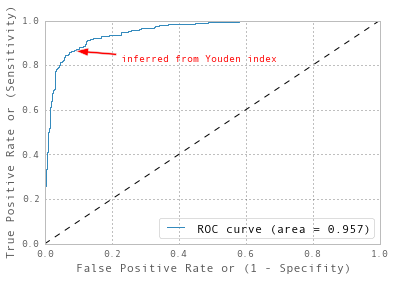

In [113]:
plot_roc_curve(Y1_test,Y_pred_1_1_probs)

Search for optimal parameters (requires additional split upfront - train, test, OoS). I would use it if you're super off in your classification attempt. It takes a while to find optimal parameters.

In [114]:
from sklearn.grid_search import GridSearchCV

In [115]:
from sklearn import svm

In [116]:
print m1_1.get_params()
print m2_1.get_params()

{'C': 1, 'intercept_scaling': 1, 'fit_intercept': True, 'penalty': 'l2', 'random_state': None, 'dual': False, 'tol': 0.0001, 'class_weight': None}
{'C': 1, 'intercept_scaling': 1, 'fit_intercept': True, 'penalty': 'l2', 'random_state': None, 'dual': False, 'tol': 0.0001, 'class_weight': None}


In [117]:
parameter_grid = [
  {'C': [0.01,0.1,1, 10, 100, 1000], 'penalty': ['l1']}, #lasso
  {'C': [0.01,0.1,1, 10, 100, 1000], 'penalty': ['l2']} #ridge
 ]

In [118]:
parameter_grid_svm = [
 {'C': [0.01,0.1,1, 10, 100, 1000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']}
 ]

#parameter_grid_svm = [
#  {'C': [0.01,0.1,1, 10, 100, 1000], 'kernel': ['linear']},
# {'C': [0.01,0.1,1, 10, 100, 1000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']},
# ]

In [119]:
m1_2=GridSearchCV(LogisticRegression(),parameter_grid,cv=5)

In [120]:
m_svm_2=GridSearchCV(svm.SVC(),parameter_grid_svm,cv=5,n_jobs=3)

In [121]:
X1.shape

(4000, 77)

In [122]:
m_svm_1=svm.SVC(kernel='rbf')

test_scores_SVM_1_1 = cross_val_score(m_svm_1, X1, Y1, cv=cv)
#test_scores_2_1 = cross_val_score(LogisticRegression(penalty = 'l2', C=1), X2, Y2, cv=cv)


#print(test_scores)
print test_scores_SVM_1_1.mean()


0.905625


Uncomment the cell below if you want to perform the grid search. Note that it may take a while (see: above).

In [123]:
m1_2.fit(X1_train,Y1_train)

GridSearchCV(cv=5,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}, {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

The svm grid-search really takes for ever.

In [124]:
m_svm_2.fit(X1_train,Y1_train)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


GridSearchCV(cv=5,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=3,
       param_grid=[{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [125]:
m2_2.best_estimator_

NameError: name 'm2_2' is not defined

In [ ]:
m1_2.best_estimator_

In [ ]:
#m2.best_estimator_

The difference between what we were using before and the best model us the **penalty (lasso, L1)** and the **regularization term (100 instead of 1)**.

In [ ]:
print m1_2.best_score_
print m1_2.score(X1_test,Y1_test)
print m2_2.best_score_

In [ ]:
Y_pred_1_2=m1_2.predict(X1_test)
Y_pred_svm=m2_2.predict(X1_test)

In [ ]:
Y_pred_1_2_probs=m1_2.predict_proba(X1_test)
plot_roc_curve(Y1_test,Y_pred_1_2_probs)



In [ ]:
print classification_report(Y1_test,Y_pred_1_2)
print classification_report(Y1_test,Y_pred_svm)

**OoS**

In [ ]:
Y1_OoS=X1_OoS['Target'].values
X1_OoS.drop('Target',axis=1,inplace =True)

In [ ]:
Y_pred_1_OoS=m1_2.predict(X1_OoS.values)

In [ ]:
print classification_report(Y1_OoS,Y_pred_1_OoS)
print accuracy_score(Y1_OoS, Y_pred_1_OoS)


If the OoS will be unbalanced, the underrepresented class might not be picked up correctly. You need a similar sample balance (at least for logistic regression).    

Again, nothing got mis-classified.



**Mixing**

In [ ]:
df_mix_800_trans=pd.read_csv('../Data/mixing_df_mix_800_no_DNA_trans.csv')
df_mix_890_trans=pd.read_csv('../Data/mixing_df_mix_890_no_DNA_trans.csv')
df_mix_875_trans=pd.read_csv('../Data/mixing_df_mix_875_no_DNA_trans.csv')
df_mix_850_trans=pd.read_csv('../Data/mixing_df_mix_850_no_DNA_trans.csv')

In [ ]:
df_mix_890_trans.drop('Unnamed: 0',inplace=True,axis=1)
df_mix_800_trans.drop('Unnamed: 0',inplace=True,axis=1)
df_mix_850_trans.drop('Unnamed: 0',inplace=True,axis=1)
df_mix_875_trans.drop('Unnamed: 0',inplace=True,axis=1)

In [ ]:
list(df_mix_890_trans.columns).__len__(), list(X1_train_input.columns).__len__()
k=set(list(df_mix_890_trans.columns))
k.difference(set(list(X1_train_input.columns)))

k=set(list(X1_train_input.columns))
k.difference(set(list(df_mix_890_trans.columns)))
#.di list(X1_train_input.columns)

In [ ]:
print df_mix_890_trans.shape
print df_mix_800_trans.shape
print df_mix_850_trans.shape
print df_mix_875_trans.shape

In [ ]:
print classification_report(Y_800.values,m1_2.predict(df_mix_800_trans.values))
print accuracy_score(Y_800.values,m1_2.predict(df_mix_800_trans.values))

cm=confusion_matrix(Y_800.values, m1_2.predict(df_mix_800_trans.values))
plt.matshow(cm)
plt.title('STG8 - 100%')
plt.colorbar()

In [ ]:
print classification_report(Y_890.values,m1_2.predict(df_mix_890_trans.values))
print accuracy_score(Y_890.values,m1_2.predict(df_mix_890_trans.values))

cm=confusion_matrix(Y_890.values, m1_2.predict(df_mix_890_trans.values))

print(cm)

plt.matshow(cm)
plt.title('STG8 - 90% / CSF - 10%')
plt.colorbar()

In [ ]:
print classification_report(Y_875.values,m1_2.predict(df_mix_875_trans.values))
print accuracy_score(Y_875.values,m1_2.predict(df_mix_875_trans.values))

cm=confusion_matrix(Y_875.values, m1_2.predict(df_mix_875_trans.values))

print(cm)

plt.matshow(cm)
plt.title('STG8 - 75% / CSF - 25%')
plt.colorbar()

In [ ]:
print classification_report(Y_850.values,m1_2.predict(df_mix_850_trans.values))
print accuracy_score(Y_850.values,m1_2.predict(df_mix_850_trans.values))

cm=confusion_matrix(Y_850.values, m1_2.predict(df_mix_850_trans.values))

print(cm)

plt.matshow(cm)
plt.title('STG8 - 50% / CSF - 50%')
plt.colorbar()

Evaluating **feature performance**:    

**1. Scikit**     
* We already removed low variance features (see: above). Now, let's try **univariate feature selection methods**. As input, we will only use the dataset with the near zero variance features removed. This test looks at every feature and the target labels and estimates whether a particular variable is in fact different between target classes.


In [ ]:
np.shape(sklearn.feature_selection.univariate_selection.f_classif(X1_train,Y1_train)[1])

In [ ]:
np.shape(sklearn.feature_selection.univariate_selection.f_classif(X2_train,Y2_train)[1])

In [ ]:
sklearn.feature_selection.univariate_selection.f_classif(X1_train,Y1_train)[1]

In [ ]:
sklearn.feature_selection.univariate_selection.f_classif(X2_train,Y2_train)[1]

Sorting: 

In [ ]:
a1=np.array(sklearn.feature_selection.univariate_selection.f_classif(X1_train,Y1_train)[1])
b1=np.array(CSF_STG8_no_Y_transformed.columns.tolist())
idx1=a1.argsort()
b1_sorted=b1[idx1]
a1_sorted=a1[idx1]

In [ ]:
a2=np.array(sklearn.feature_selection.univariate_selection.f_classif(X2_train,Y2_train)[1])
b2=np.array(CSF_STG8_no_Y_transf_nzv.columns.tolist())
idx2=a2.argsort()
b2_sorted=b2[idx2]
a2_sorted=a2[idx2]

In [ ]:
zip(b1_sorted,a1_sorted)

In [ ]:
zip(b2_sorted,a2_sorted)

In [ ]:
my_file = open('../Data/mixing_1_no_DNA_univariate.tsv','w')

idx=1
for name, p_val in zip(b1_sorted,a1_sorted):
    if re.match('.*DNA.*',name) != None:
        my_file.write(str(idx) + '\tDNA\t' + str(re.match('.*DNA.*',name).group(0)) + '\t'+ str(p_val) + '\n')
    elif re.match('.*chromatin.*',name, flags=re.IGNORECASE) != None:
        my_file.write(str(idx)+ '\tchromatin\t'+ str(re.match('.*chromatin.*',name, flags=re.IGNORECASE).group(0)) + '\t' + str(p_val)+'\n')
    else: 
        my_file.write(str(idx) + '\tOTHER\t' + str(name) + '\t' + str(p_val) +'\n')
    idx+=1
    
my_file.close()

In [ ]:
%R -i df_mix

In [ ]:
%%R
print(dim(CSF_STG8[CSF_STG8$Metadata_Type=='CSF',]))
dim(CSF_STG8[CSF_STG8$Metadata_Type=='STG',])

In [ ]:
%%R
print(summary(CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),'Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA']))
IQR=summary(CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),'Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA'])[[5]]-summary(CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),'Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA'])[[2]]
IQR

In [ ]:
%%R
print(summary(CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),'Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA']))
IQR=summary(CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),'Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA'])[[5]]-summary(CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),'Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA'])[[2]]
IQR.lim=1.5*IQR
print(IQR.lim)

plot=ggplot()
df_mix$Metadata_Treatment=factor(df_mix$Metadata_Treatment)
factor_order=c(800, 890, 875, 850)

#plot=plot+geom_violin(data=CSF_STG8[CSF_STG8$Metadata_Type=='STG',], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
plot = plot+geom_violin(data=df_mix,aes(x=Metadata_Treatment,y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Treatment)))
plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==800,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==890,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==875,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==850,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))

plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF') & (CSF_STG8$Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA<0.06),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Type)))
plot=plot+scale_fill_manual(values=c('#E30D16','#C6252B','#9F4448', '#815C5D','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot

In [ ]:
%%R
plot=ggplot()
df_mix$Metadata_Treatment=factor(df_mix$Metadata_Treatment)
factor_order=c(800, 890, 875, 850)

#plot=plot+geom_violin(data=CSF_STG8[CSF_STG8$Metadata_Type=='STG',], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
plot = plot+geom_violin(data=df_mix,aes(x=Metadata_Treatment,y=Intensity_MeanIntensityEdge_DNA,fill=factor(Metadata_Treatment)))
plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==800,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==890,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==875,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==850,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))

plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Intensity_MeanIntensityEdge_DNA,fill=factor(Metadata_Type)))
plot=plot+scale_fill_manual(values=c('#E30D16','#C6252B','#9F4448', '#815C5D','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot

In [ ]:
%%R
plot=ggplot()
df_mix$Metadata_Treatment=factor(df_mix$Metadata_Treatment)
factor_order=c(800, 890, 875, 850)

#plot=plot+geom_violin(data=CSF_STG8[CSF_STG8$Metadata_Type=='STG',], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
plot = plot+geom_violin(data=df_mix,aes(x=Metadata_Treatment,y=Intensity_MeanIntensity_DNA,fill=factor(Metadata_Treatment)))
plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==800,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==890,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==875,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==850,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))

plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Intensity_MeanIntensity_DNA,fill=factor(Metadata_Type)))
plot=plot+scale_fill_manual(values=c('#E30D16','#C6252B','#9F4448', '#815C5D','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot

In [ ]:
%%R
plot=ggplot()
df_mix$Metadata_Treatment=factor(df_mix$Metadata_Treatment)
factor_order=c(800, 890, 875, 850)

#plot=plot+geom_violin(data=CSF_STG8[CSF_STG8$Metadata_Type=='STG',], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
plot = plot+geom_violin(data=df_mix,aes(x=Metadata_Treatment,y=Intensity_MedianIntensity_DNA,fill=factor(Metadata_Treatment)))
plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==800,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==890,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==875,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==850,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))

plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Intensity_MedianIntensity_DNA,fill=factor(Metadata_Type)))
plot=plot+scale_fill_manual(values=c('#E30D16','#C6252B','#9F4448', '#815C5D','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot

In [ ]:
%%R
plot=ggplot()
df_mix$Metadata_Treatment=factor(df_mix$Metadata_Treatment)
factor_order=c(800, 890, 875, 850)

#plot=plot+geom_violin(data=CSF_STG8[CSF_STG8$Metadata_Type=='STG',], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
plot = plot+geom_violin(data=df_mix,aes(x=Metadata_Treatment,y=Mean_FilteredChromatin_AreaShape_MaxFeretDiameter,fill=factor(Metadata_Treatment)))
plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==800,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==890,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==875,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==850,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))

plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_AreaShape_MaxFeretDiameter,fill=factor(Metadata_Type)))
plot=plot+scale_fill_manual(values=c('#E30D16','#C6252B','#9F4448', '#815C5D','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot

In [ ]:
%%R
plot=ggplot()
df_mix$Metadata_Treatment=factor(df_mix$Metadata_Treatment)
factor_order=c(800, 890, 875, 850)

#plot=plot+geom_violin(data=CSF_STG8[CSF_STG8$Metadata_Type=='STG',], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
plot = plot+geom_violin(data=df_mix,aes(x=Metadata_Treatment,y=Mean_FilteredChromatin_AreaShape_Area,fill=factor(Metadata_Treatment)))
plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==800,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==890,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==875,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))
#plot=plot+geom_violin(data=df_mix[df_mix$Metadata_Treatment==850,],aes(x=factor(Metadata_Treatment),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA))

plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_AreaShape_Area,fill=factor(Metadata_Type)))
plot=plot+scale_fill_manual(values=c('#E30D16','#C6252B','#9F4448', '#815C5D','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot

This one probably means that if we take all the tiny chromatn speckles. On average they will have smaller area than one big blob of the CSF.

The first 34 features relate to DNA (intensity) and chromatin (shape and metric). The first 'different' feature is **Solidity** (position 35), **median, mean, maximum radius** (37, 42, 48), **form factor** (46), **area** (53, 54). **Length** is 64, 65. **Width** is 77, 78. **Total MT** signal is 76. Aspect ratio is only 118. Eccentricity is 112.

If you look at this original analysis, you can see that the best predictors relate to DNA and chromatin. Only around the position 45, features such as form factor or solidity tend to come up. Area is ~65. Width and length are in the middle of the pack (~75). Eccentricity is only ~133.

In [ ]:
idx=1
for name, p_val in zip(b2_sorted,a2_sorted):
    if re.match('.*DNA.*',name) != None:
        print idx, 'DNA\t', re.match('.*DNA.*',name).group(0), '\t', p_val
    elif re.match('.*chromatin.*',name, flags=re.IGNORECASE) != None:
        print idx, 'chromatin\t', re.match('.*chromatin.*',name, flags=re.IGNORECASE).group(0), '\t', p_val
    else: 
        print idx, 'OTHER\t', name, '\t', p_val
    idx+=1

The analysis above gives the full list with ranking. Let's try to select. 

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFwe

In [ ]:
X_new_SelectFwe=SelectFwe(X_new)

In [ ]:
X_new_SelectFwe

In [ ]:
max(df_mix.Parent_Spindles), max(df_mix.ObjectNumber)

In [ ]:
np.all(np.equal(df_mix.ObjectNumber,df_mix.Number_Object_Number))
#df_mix.ObjectNumber==df_mix.Number_Object_Number